In [1]:
import numpy as np
import pandas as pd
from data_processing.csv_reader import CSVReader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from time_series_processing.differencing import Differencer

In [2]:
path = "../raw_data/AAPL.csv"
csvr = CSVReader(path=path)


csvr.get_properties()
df = csvr.get_df()

         Date      Open      High       Low     Close  Adj Close     Volume
0  1980-12-12  0.128348  0.128906  0.128348  0.128348   0.099449  469033600
1  1980-12-15  0.122210  0.122210  0.121652  0.121652   0.094261  175884800
2  1980-12-16  0.113281  0.113281  0.112723  0.112723   0.087343  105728000
3  1980-12-17  0.115513  0.116071  0.115513  0.115513   0.089504   86441600
4  1980-12-18  0.118862  0.119420  0.118862  0.118862   0.092099   73449600


In [4]:
mmscaler1 = MinMaxScaler(feature_range=(0,1))
mmscaler2 = MinMaxScaler(feature_range=(0,1))

df["norm_vol"] = mmscaler1.fit_transform(df["Volume"].to_numpy().reshape(-1, 1))
df["norm_close"] = mmscaler2.fit_transform(df["Close"].to_numpy().reshape(-1, 1))

In [5]:
df["returns"] = df["Close"].pct_change()
df["log_returns"] = np.log(1 + df["returns"])
df["fluctuation"] = df["High"]/df["Low"] - 1
df.dropna(inplace=True)

df

,Date,Open,High,Low,Close,Adj Close,Volume,norm_vol,norm_close,returns,log_returns,fluctuation
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094261,175884800,0.023699,0.000369,-0.052171,-0.053581,0.004587
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087343,105728000,0.014246,0.000324,-0.073398,-0.076231,0.004950
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089504,86441600,0.011647,0.000338,0.024751,0.024450,0.004831
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092099,73449600,0.009897,0.000355,0.028992,0.028580,0.004695
5,1980-12-19,0.126116,0.126674,0.126116,0.126116,0.097720,48630400,0.006553,0.000392,0.061029,0.059239,0.004424
...,...,...,...,...,...,...,...,...,...,...,...,...
10804,2023-10-20,175.309998,175.419998,172.639999,172.880005,172.880005,64189300,0.008649,0.879990,-0.014704,-0.014813,0.016103
10805,2023-10-23,170.910004,174.009995,169.929993,173.000000,173.000000,55980100,0.007543,0.880601,0.000694,0.000694,0.024010
10806,2023-10-24,173.050003,173.669998,171.449997,173.440002,173.440002,43816600,0.005904,0.882842,0.002543,0.002540,0.012948
10807,2023-10-25,171.880005,173.059998,170.649994,171.100006,171.100006,57157000,0.007701,0.870927,-0.013492,-0.013584,0.014122


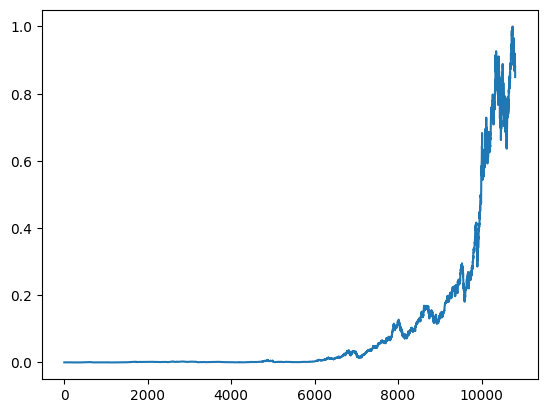

In [6]:
plt.figure()
plt.plot(range(len(df["norm_close"])), df["norm_close"])
plt.show()

In [7]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["log_returns"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -26.518892
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# norm_vol	norm_close	returns	norm_returns	log_returns	fluctuation	log_diff_close

new_arr = df[["log_returns", "fluctuation", "norm_vol", "norm_close"]].to_numpy()
new_arr.shape

(10808, 4)

In [10]:
new_arr

array([[-5.35808151e-02,  4.58685431e-03,  2.36989104e-02,
         3.69372053e-04],
       [-7.62310278e-02,  4.95018763e-03,  1.42459064e-02,
         3.23908919e-04],
       [ 2.44495959e-02,  4.83062512e-03,  1.16472357e-02,
         3.38114557e-04],
       ...,
       [ 2.54013528e-03,  1.29483875e-02,  5.90389662e-03,
         8.82841697e-01],
       [-1.35835138e-02,  1.41224968e-02,  7.70139670e-03,
         8.70927311e-01],
       [-2.49133092e-02,  3.44661500e-02,  9.47841615e-03,
         8.49491527e-01]])

In [11]:
X = []
y = []

context_size = 30
for i in range(context_size, new_arr.shape[0]):
    X.append(new_arr[i-context_size:i])
    y.append(new_arr[i, -1])

In [12]:
X = np.stack(X, axis=0).squeeze()
y = np.stack(y, axis=0).squeeze()

In [13]:
X.shape

(10778, 30, 4)

In [14]:
y.shape

(10778,)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle=False, test_size=0.1)

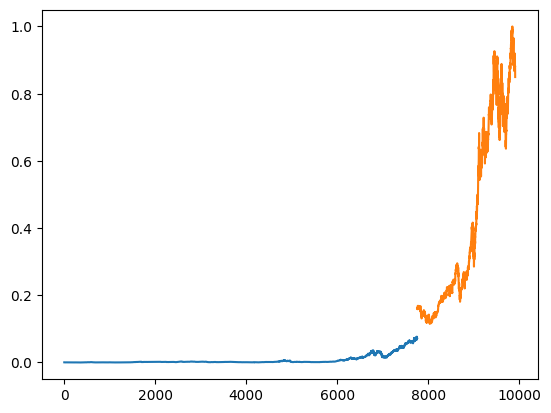

In [17]:
plt.figure()
plt.plot(range(len(y_train)), y_train)
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test)
plt.show()

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [19]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2) -> None:
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=num_layers, dropout=dropout)
        self.linear = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        out = self.linear(x[:, -1, :])
        return out

In [26]:
lstm = LSTMCell(4, 10, 1, num_layers=1)
lstm = lstm.to(torch.cuda.current_device())

c:\Users\YuweiZhu\anaconda3\envs\terminal\Lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [27]:
from torch.utils.data import DataLoader

In [28]:
loader = DataLoader(list(zip(X_train, y_train)), batch_size=16)

In [29]:
def val_score(model, X_val, y_val):
    val_loader = DataLoader(list(zip(X_val, y_val)), batch_size=16)
    
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for (xval, yval) in val_loader:
            xval = xval.to(0)
            yval = yval.to(0)
            xval = xval.float()
            res = model(xval)
            loss = F.mse_loss(res.squeeze(), yval.squeeze()).item()
            total_loss +=  loss
            
    return loss

In [30]:
torch.cuda.is_available()

True

In [31]:
epochs = 100

mse = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)
losses = [10]
storage = []

for e in range(epochs):
    lstm.train()
    for (Xt, yt) in loader:
        Xt = Xt.to(0)
        yt = yt.to(0)
        #forward
        y_pred = lstm(Xt.float())
        
        loss = mse(y_pred.squeeze(), yt.float())

        # backward pass
        lstm.zero_grad()
        loss.backward()
        # update weights
        optimizer.step()


    losses.append(val_score(lstm, X_val, y_val))
    print(losses[-1])

    if losses[-1] > losses[-2]:
        storage.append((losses[-1], lstm))

0.00758479285514872
0.00686465303435087
0.006388763665335919
0.006041682752314672
0.005773814991659675
0.005569320150769988
0.005396683242802509
0.005285178435618674
0.005136488553709008
0.005250780764220839
0.004993212163061217
0.004972962698074966
0.004979931372620248
0.004956606096456291
0.0048213929041846645
0.004901153607326199
0.004949509155628186
0.004698052477899352
0.004535529809601903
0.004257637577196525
0.003952426026357227
0.0035755204694919145
0.0031569551250565085
0.0028024226310584058
0.002438098709197832
0.002082088030347959
0.0017643286554919358
0.001345185812434566
0.0009438061449265065
0.0004466901067408116
0.00014164164456227448
1.1155343378276602e-05
1.1796522145303291e-05
3.503422666887713e-05
5.457617732215195e-05
8.840109048672224e-05
0.00011597901705629764
0.00020667800710337582
0.0003060969714470091
0.00048369075221237507
0.0006923117557050375
0.0008655439656398655
0.0011530992891827453
0.0013524967789293172
0.0017867542220656443
0.0020924378626524433
0.00249

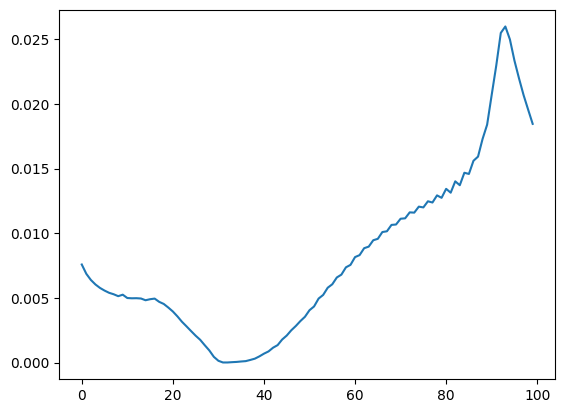

In [32]:
plt.figure()
plt.plot(range(len(losses)-1), losses[1:])
plt.show()

In [33]:
storage = sorted(storage, key=lambda x: x[0])

In [34]:
storage

[(1.1796522145303291e-05,
  LSTMCell(
    (lstm): LSTM(4, 10, batch_first=True, dropout=0.2)
    (linear): Linear(in_features=10, out_features=1, bias=True)
  )),
 (3.503422666887713e-05,
  LSTMCell(
    (lstm): LSTM(4, 10, batch_first=True, dropout=0.2)
    (linear): Linear(in_features=10, out_features=1, bias=True)
  )),
 (5.457617732215195e-05,
  LSTMCell(
    (lstm): LSTM(4, 10, batch_first=True, dropout=0.2)
    (linear): Linear(in_features=10, out_features=1, bias=True)
  )),
 (8.840109048672224e-05,
  LSTMCell(
    (lstm): LSTM(4, 10, batch_first=True, dropout=0.2)
    (linear): Linear(in_features=10, out_features=1, bias=True)
  )),
 (0.00011597901705629764,
  LSTMCell(
    (lstm): LSTM(4, 10, batch_first=True, dropout=0.2)
    (linear): Linear(in_features=10, out_features=1, bias=True)
  )),
 (0.00020667800710337582,
  LSTMCell(
    (lstm): LSTM(4, 10, batch_first=True, dropout=0.2)
    (linear): Linear(in_features=10, out_features=1, bias=True)
  )),
 (0.0003060969714470091,


In [35]:
lstm = storage[0][1]

In [36]:
y_eval = []
X_test = torch.tensor(X_test)

lstm.eval()
with torch.no_grad():
    for x in X_test:
        x = x.to(0)

        
        x = x.unsqueeze(0).float()
        res = lstm(x).item()
        print(res)
        y_eval.append(res)

0.2966309189796448
0.2974693179130554
0.2982352077960968
0.29962536692619324
0.30178597569465637
0.3026397228240967
0.302638441324234
0.30399805307388306
0.3040168881416321
0.3006386458873749
0.30162301659584045
0.30332550406455994
0.3058965504169464
0.31032222509384155
0.3157977759838104
0.32410305738449097
0.32137811183929443
0.3163982331752777
0.3052816390991211
0.303507000207901
0.30696335434913635
0.30299103260040283
0.2977410852909088
0.29665717482566833
0.30193188786506653
0.30208852887153625
0.30075111985206604
0.3010626435279846
0.30643993616104126
0.3105793595314026
0.3141535222530365
0.3179306387901306
0.31923359632492065
0.32221198081970215
0.32702016830444336
0.32157376408576965
0.32402756810188293
0.32751569151878357
0.3260941505432129
0.3252236545085907
0.3236736059188843
0.3234541714191437
0.32114943861961365
0.3187517523765564
0.3143380284309387
0.31082451343536377
0.31273573637008667
0.3131890594959259
0.3113403022289276
0.3091582655906677
0.30896472930908203
0.309011

In [ ]:
y_gen = []
#y_total = np.concatenate([y_train, y_val, y_eval], axis=0)

lstm.eval()
with torch.no_grad():
    for x in X_test:
        x = x.to(0)

        
        x = x.unsqueeze(0).float()
        res = lstm(x).item()
        print(res)
        y_eval.append(res)

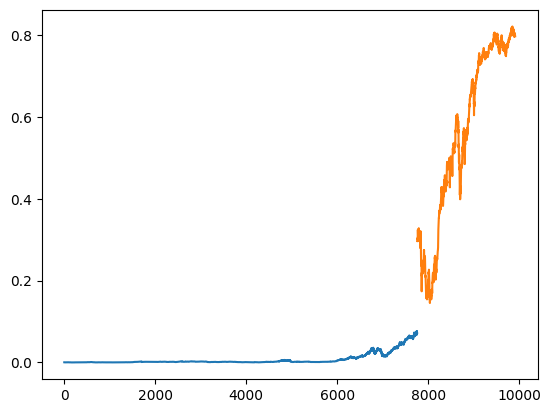

In [37]:
plt.figure()
plt.plot(range(len(y_train)), y_train)
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_eval)
plt.show()

In [38]:
y_eval = np.array(y_eval)
y_total = np.concatenate([y_train, y_val, y_eval], axis=0)


In [39]:
y_total = mmscaler2.inverse_transform(y_total.reshape(-1,1))

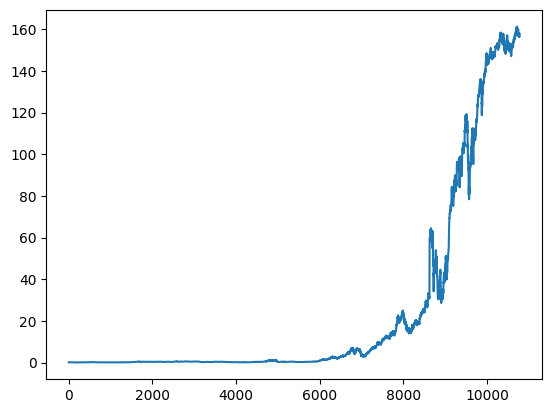

In [40]:
plt.figure()
plt.plot(range(len(y_total)), y_total)
plt.show()

In [44]:
len(df["Close"])

10808

In [45]:
len(y_total)

10778

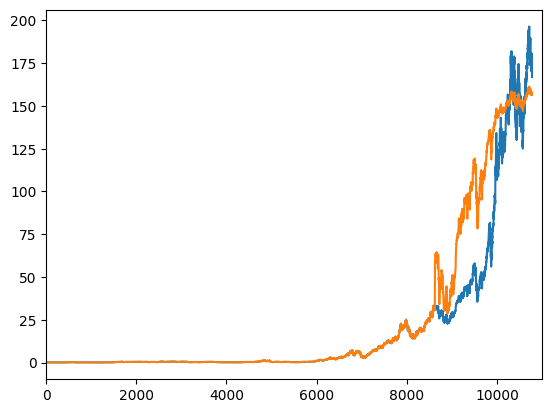

In [46]:
plt.figure()
plt.plot(range(len(df["Close"][context_size:])), df["Close"][context_size:])
plt.plot(range(len(y_total)), y_total)
#plt.xticks(range(len(df)),df["Date"])
plt.xlim(0, 11000)
#plt.ylim(0, 200)
plt.show()

In [47]:
y_test

array([0.16014894, 0.15962704, 0.16084903, ..., 0.8828417 , 0.87092731,
       0.84949153])

In [48]:
y_eval

array([0.29663092, 0.29746932, 0.29823521, ..., 0.79770404, 0.79836363,
       0.79723448])

In [49]:
diff = Differencer()

In [50]:
y_test_diff = diff.fit_difference(y_test)
y_eval_diff = diff.fit_difference(y_eval)

In [51]:
y_test_diff

array([-0.0005219 ,  0.00122199,  0.00068737, ...,  0.00224033,
       -0.01191439, -0.02143578])

In [52]:
y_eval_diff

array([ 0.0008384 ,  0.00076589,  0.00139016, ..., -0.0013696 ,
        0.00065958, -0.00112915])

In [53]:
total = len(y_eval_diff)
corr = 0

for i in range(total):

    if y_eval_diff[i] > 0 and y_test_diff[i] > 0:
        corr += 1
    elif y_eval_diff[i] < 0 and y_test_diff[i] < 0:
        corr += 1

print(corr/total)

0.48677494199535964
